In [1]:
from typing import Annotated
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, state, START, END

In [2]:
load_dotenv()

True

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGroq(model="llama3-8b-8192")

from langchain.prompts import PromptTemplate

system_prompt_query_classification = PromptTemplate.from_template(
    """
    You are an intelligent hotel assistant.

    Given this user message, classify it into one of these intents:
    - book_room
    - recommend_food
    - recommend_room
    - answer_faq
    - others

    User message: "{query}"

    Respond with only the intent.
    """
)

def _query_classification(query):

    prompt = system_prompt_query_classification.format_prompt(query=query)
    response = llm.invoke(prompt.to_messages())
    intent = response.content.strip()

    return intent


def book_room_node(state: State):
    print("📦 Booking a room...")
    return state

def recommend_food_node(state: State):
    print("🍕 Recommending food...")
    return state

def recommend_room_node(state: State):
    print("🛏️ Recommending room...")
    return state

def answer_faq_node(state: State):
    print("❓ Answering FAQ...")
    return state

# Node functionality
def query_classification(state: State): 

    last_message = state["messages"][-1]
    query = last_message.content
    intent = _query_classification(query)

    return {**state, "intent": intent}
    # return {"messages":[llm.invoke(state["messages"])]}


In [4]:
graph_builder = StateGraph(State)

graph_builder.add_node(
    node="classify_query",
    action=query_classification
)
graph_builder.add_edge(
    start_key=START,
    end_key="classify_query",
)
graph_builder.add_node(
    node="book_room",
    action=book_room_node
)
graph_builder.add_node(
    node="recommend_food",
    action=recommend_food_node
)
graph_builder.add_node(
    node="recommend_room",  
    action=recommend_room_node
)
graph_builder.add_node(
    node="answer_faq",
    action=answer_faq_node
)

graph_builder.add_conditional_edges(
    "classify_query",
    lambda state: state["intent"],
    {
        "book_room": "book_room",
        "recommend_food": "recommend_food",
        "recommend_room": "recommend_room",
        "answer_faq": "answer_faq",
        "others": END  
    }
)

graph_builder.add_edge(
    "book_room",
    end_key=END
)
graph_builder.add_edge(
    "recommend_food",
    end_key=END
)   
graph_builder.add_edge(
    "recommend_room",
    end_key=END
)
graph_builder.add_edge(
    "answer_faq",
    end_key=END
)

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

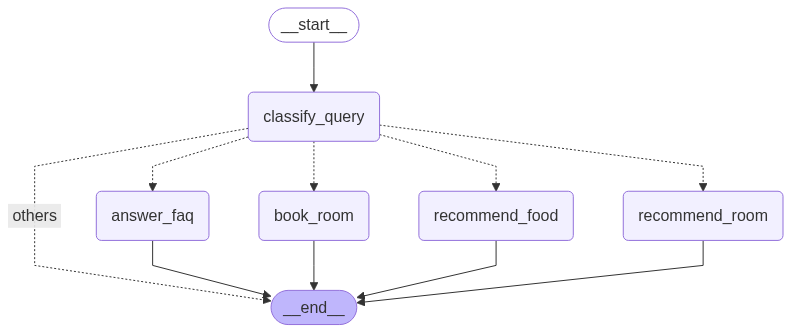

In [5]:
graph

In [6]:
config = {"configurable": {"thread_id": "1", "username": "user1"}}

In [7]:
output = graph.invoke({"messages": ["Hello, how are you?"]},config)

❓ Answering FAQ...


In [8]:
output['messages']

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='62c27ab5-ff74-4312-ab61-f97bc305ff2f')]

In [9]:
graph.invoke({"messages": ["how is the weather there?"]},config)

❓ Answering FAQ...


{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='62c27ab5-ff74-4312-ab61-f97bc305ff2f'),
  HumanMessage(content='how is the weather there?', additional_kwargs={}, response_metadata={}, id='b6a1fcc0-a447-4db4-ba75-62bd8437055c')]}

In [10]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='62c27ab5-ff74-4312-ab61-f97bc305ff2f'), HumanMessage(content='how is the weather there?', additional_kwargs={}, response_metadata={}, id='b6a1fcc0-a447-4db4-ba75-62bd8437055c')]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05e83c-60f2-6d03-8006-ad1cfa93c739'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}, 'thread_id': '1', 'username': 'user1'}, created_at='2025-07-11T18:20:50.509520+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05e83c-60f0-6d26-8005-45bcdb2cc202'}}, tasks=(), interrupts=())

In [11]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='62c27ab5-ff74-4312-ab61-f97bc305ff2f'), HumanMessage(content='how is the weather there?', additional_kwargs={}, response_metadata={}, id='b6a1fcc0-a447-4db4-ba75-62bd8437055c')]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05e83c-60f2-6d03-8006-ad1cfa93c739'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}, 'thread_id': '1', 'username': 'user1'}, created_at='2025-07-11T18:20:50.509520+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05e83c-60f0-6d26-8005-45bcdb2cc202'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='62c27ab5-ff74-4312-ab61-f97bc305ff2f'), HumanMessage(content='how is the weather there?', additional_kwargs={}, response_metadata={}, i

In [12]:
from langgraph.store.memory import InMemoryStore

In [13]:
in_memory_store = InMemoryStore()

In [14]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

In [15]:
memory_id = "id1"

In [16]:
memory = {'food_preference':'I like pizza'}

In [17]:
in_memory_store.put(namespace_for_memory, memory_id, memory)

In [18]:
in_memory_store.search(namespace_for_memory)[-1].dict()

{'namespace': ['1', 'memories'],
 'key': 'id1',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-07-11T18:20:50.616444+00:00',
 'updated_at': '2025-07-11T18:20:50.616449+00:00',
 'score': None}

In [19]:
in_memory_store.get(namespace_for_memory, memory_id)

Item(namespace=['1', 'memories'], key='id1', value={'food_preference': 'I like pizza'}, created_at='2025-07-11T18:20:50.616444+00:00', updated_at='2025-07-11T18:20:50.616449+00:00')

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../"))  

In [8]:
config = {"configurable": {"thread_id": "1", "username": "user1"}}

In [19]:
from langchain_core.documents import Document

In [12]:
from app.graph import build_chatbot_graph

if __name__ == "__main__":
    graph = build_chatbot_graph()

    state = {"messages": [{"role": "user", "content": "can i bring my pet?"}]}

    output = graph.invoke(state, config)
    # state = {"messages": [{"role": "user", "content": "How are you"}]}
    # output = graph.invoke(state, config)

    print("Final State:", output)

Final State: {'messages': [SystemMessage(content='\n    You are a smart and helpful hotel assistant AI. You can answer questions, perform tasks, and access external tools when needed.\n\n    You must decide when to:\n    - Answer directly using your own knowledge (e.g., general queries).\n    - Use tools like:\n    - `book_room`: For room bookings or availability.\n    - `faq_rag`: To answer hotel-related FAQs (e.g., check-in time, pet policy).\n    - `recommend_food`: For food or restaurant recommendations.\n    - `recommend_room`: To suggest rooms based on user preferences.\n\n    Always:\n    - Understand user intent clearly.\n    - Ask clarifying questions if needed.\n    - Call external tools only when necessary.\n    - Keep responses friendly, short, and useful.\n    - If unsure, say "Let me find that for you" and call the relevant tool.\n\n    Maintain the context of the conversation and personalize the experience when possible.\n\n    Do not fabricate answers. Delegate to tools

In [14]:
state = {"messages": [{"role": "user", "content": "Its a dog"}]}

output = graph.invoke(state, config)

In [15]:
output

{'messages': [SystemMessage(content='\n    You are a smart and helpful hotel assistant AI. You can answer questions, perform tasks, and access external tools when needed.\n\n    You must decide when to:\n    - Answer directly using your own knowledge (e.g., general queries).\n    - Use tools like:\n    - `book_room`: For room bookings or availability.\n    - `faq_rag`: To answer hotel-related FAQs (e.g., check-in time, pet policy).\n    - `recommend_food`: For food or restaurant recommendations.\n    - `recommend_room`: To suggest rooms based on user preferences.\n\n    Always:\n    - Understand user intent clearly.\n    - Ask clarifying questions if needed.\n    - Call external tools only when necessary.\n    - Keep responses friendly, short, and useful.\n    - If unsure, say "Let me find that for you" and call the relevant tool.\n\n    Maintain the context of the conversation and personalize the experience when possible.\n\n    Do not fabricate answers. Delegate to tools when they ca

In [23]:
tools = []

In [24]:
llm = ChatGroq(model="llama3-8b-8192")
llm_with_tool = llm.bind_tools(tools=[])

In [25]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_LLM(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

In [26]:
builder = StateGraph(State)
builder.add_node(
    node="tool_calling_LLM",
    action=tool_calling_LLM
)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(
    start_key=START,
    end_key="tool_calling_LLM"
)
builder.add_conditional_edges(
    "tool_calling_LLM",
    tools_condition,
)
builder.add_edge(
    "tools",
    "tool_calling_LLM"
)
    
builder.add_edge(
    "tools",
    end_key=END
)

graph = builder.compile()

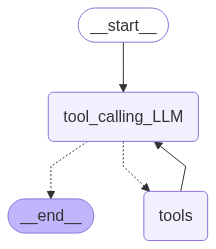

In [27]:
graph

In [28]:
graph.invoke({"messages": ["how is the weather there?"]},config)

{'messages': [HumanMessage(content='how is the weather there?', additional_kwargs={}, response_metadata={}, id='0d4b7a01-79a7-4175-8b91-5e1012ec8980'),
  AIMessage(content="I'm just an AI, I don't have a physical presence, so I'm not located in a specific place and don't have access to real-time weather information. However, I can tell you that the weather can vary greatly depending on the location and the time of year.\n\nIf you're asking about the weather in a specific location, I can try to provide you with some general information. Please let me know where you're interested in learning about the weather, and I'll do my best to provide you with some information.\n\nIt's also worth noting that the weather can be affected by many factors, such as the time of year, the location, and the weather patterns in the region.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 16, 'total_tokens': 156, 'completion_time': 0.169784477, 'prompt_tim

In [29]:
graph.invoke({"messages": ["how is the room "]},config)

{'messages': [HumanMessage(content='how is the room ', additional_kwargs={}, response_metadata={}, id='06a884dd-62e4-4d2e-aa2c-cbcf309f31a2'),
  AIMessage(content="I'm just an AI, I don't have the ability to physically perceive or interact with the world, so I don't have any information about the room you're referring to.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 15, 'total_tokens': 52, 'completion_time': 0.045188121, 'prompt_time': 0.008570638, 'queue_time': 0.736696928, 'total_time': 0.053758759}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--742f90c2-f02c-4be9-a31e-b004484356d2-0', usage_metadata={'input_tokens': 15, 'output_tokens': 37, 'total_tokens': 52})]}

In [30]:
from app.graph import build_chatbot_graph

if __name__ == "__main__":
    graph = build_chatbot_graph()

    state = {"messages": [{"role": "user", "content": "Can you book a room for me?"}]}
    output = graph.invoke(state, config)

    print("Final State:", output)

Final State: {'messages': [SystemMessage(content='\n    You are a smart and helpful hotel assistant AI. You can answer questions, perform tasks, and access external tools when needed.\n\n    You must decide when to:\n    - Answer directly using your own knowledge (e.g., general queries).\n    - Use tools like:\n    - `book_room`: For room bookings or availability.\n    - `faq_rag`: To answer hotel-related FAQs (e.g., check-in time, pet policy).\n    - `recommend_food`: For food or restaurant recommendations.\n    - `recommend_room`: To suggest rooms based on user preferences.\n\n    Always:\n    - Understand user intent clearly.\n    - Ask clarifying questions if needed.\n    - Call external tools only when necessary.\n    - Keep responses friendly, short, and useful.\n    - If unsure, say "Let me find that for you" and call the relevant tool.\n\n    Maintain the context of the conversation and personalize the experience when possible.\n\n    Do not fabricate answers. Delegate to tools